In [298]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random


from termcolor import colored

from sklearn.model_selection import train_test_split, cross_validate, KFold, learning_curve,validation_curve
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer


from mlxtend.evaluate import bias_variance_decomp

# Model
# --------------------------------------------------------------------
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics

In [299]:
def ROC(X_test,y_test):
    y_pred_proba = model.predict_proba(X_test)
    lr_probs = y_pred_proba[:,1]
    ns_probs = [0 for _ in range(len(y_test))]
    ns_auc = metrics.roc_auc_score(y_test, ns_probs)
    lr_auc = metrics.roc_auc_score(y_test, lr_probs)
    ns_fpr, ns_tpr, thresholds  = metrics.roc_curve(y_test,ns_probs)
    lr_fpr, lr_tpr, thresholds = metrics.roc_curve(y_test, lr_probs)
    plt.plot(ns_fpr,ns_tpr,linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='DT')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Treeb: ROC AUC=%.3f' % (lr_auc))

Imprime las metricas de los modelos

In [300]:
def metricas(validacion, prediccion, churm):
    
    print("Exactitud: ", metrics.accuracy_score(validacion, prediccion))
    print("Kappa: ", metrics.cohen_kappa_score(validacion, prediccion))
    
    print(colored('Metricas de los registros mineros', attrs=['bold']))
    
    print("Precisión: ",  metrics.precision_score(validacion, prediccion, labels=[1], average='macro'))
    print("Recall: ",  metrics.recall_score(validacion, prediccion, labels=[1], average='macro'))
    
    VN = churm[0,0]
    FP = churm[0,1]
    specificity = VN/(VN+FP)
    
    print("Especificidad : ", specificity)
    print("F1-score      : ", metrics.f1_score(validacion, prediccion, labels=[1], average='macro'))
    
    
    print(colored('Metricas de los registros no mineros', attrs=['bold']))
    
    print("Precisión: ",  metrics.precision_score(validacion, prediccion, labels=[0], average='macro'))
    print("Recall: ",  metrics.recall_score(validacion, prediccion, labels=[0], average='macro'))
    
    VN = churm[1,1]
    FP = churm[1,0]
    specificity = VN/(VN+FP)
    
    print("Especificidad : ", specificity)
    print("F1-score      : ", metrics.f1_score(validacion, prediccion, labels=[0], average='macro'))

In [301]:
def matriz_confusion(validacion, prediccion, cmap):
    
    churm = metrics.confusion_matrix(validacion, prediccion)
    fig,ax = plt.subplots(nrows = 1, ncols = 1,figsize = (8,6))
    sns.heatmap(churm, annot=True, ax = ax,cmap=cmap,fmt='g',annot_kws={"size": 15});

    #plt.imshow(churm, cmap=plt.cm.Blues,annot=True)
    ax.set_title("decision tree",size=15)

    ax.xaxis.set_ticklabels(['Not_mine','Mine'])
    ax.yaxis.set_ticklabels(['Not_mine','Mine'])
    ax.tick_params(labelsize = 15)
    
    return churm

In [302]:
def curva_validacion(model, X_train,y_train, param,rango):
    train_prec, eval_prec = validation_curve(estimator = model, X = X_train, y=y_train, param_name=param,param_range=rango, cv =5)
    train_mean = np.mean(train_prec, axis = 1)
    train_std = np.mean(train_prec,axis = 1)
    test_mean = np.mean(eval_prec,axis = 1)
    test_std = np.std(eval_prec,axis=1)
    
    #Grafico
    
    plt.plot(rango,train_mean,color='r', marker = 'o',markersize = 5, label = 'Entrenamiento')
    plt.fill_between(rango, train_mean + train_std, 
                 train_mean - train_std, alpha=0.15, color='r')
    plt.plot(rango, test_mean, color='b', linestyle='--', marker='s', markersize=5, label='evaluacion')
    plt.fill_between(rango, test_mean + test_std, 
                 test_mean - test_std, alpha=0.15, color='b')
    plt.grid()
    plt.legend(loc='center right')
    plt.xlabel('Cant de nodos')
    plt.ylabel('Precision')
    plt.show()

# Importar datos Puros

In [303]:
dataA = pd.read_csv('./data_identificada.csv').drop(['Second_Protocol', 'Third_Protocol','Cryptocurrency'], axis = 1)
dataA.head(1)

,Netflows,First_Protocol,p1_d,p2_d,p3_d,duration,max_d,min_d,#packets,Avg_bps,...,first_dp,second_dp,third_dp,p1_ip,p2_ip,p3_ip,p1_ib,p2_ib,p3_ib,Type
0,82,TCP,2.9595,103.6315,135.19425,6709.539,184.327,0.0,407,1266,...,443,5355.0,80.0,3.0,5.0,5.75,84.0,160.0,248.0,not_mine


# Preprocesamiento

### Imputación de valores ausentes

In [304]:
punter = pd.concat([dataA['second_sp'],dataA['second_dp'],dataA['third_sp'],dataA['third_dp']],axis=1)
imputer = SimpleImputer(missing_values = np.nan, strategy = "median")
values = imputer.fit_transform(punter)

In [305]:
punter = pd.DataFrame(values, columns = punter.columns)
dataA['second_sp'] = punter['second_sp']
dataA['second_dp'] = punter['second_dp']
dataA['third_sp'] = punter['third_sp']
dataA['third_dp'] = punter['third_dp']

In [306]:
dataCopyA = dataA
dataA.shape

(4733, 28)

In [307]:
print(colored('Como los registros benignos son los mismos para cada conjunto de datos, sacare aleatoriamente el 70% para utilizarlos para el entreno de modelos posteriores, y emular con el 30% datos de testeo', attrs=['bold']))
porcion_no_minera_conjuntoA = dataCopyA[dataCopyA.Type == "not_mine"]
porcion_no_minera_conjuntoA = porcion_no_minera_conjuntoA.sample(n=750)

Como los registros benignos son los mismos para cada conjunto de datos, sacare aleatoriamente el 70% para utilizarlos para el entreno de modelos posteriores, y emular con el 30% datos de testeo


In [308]:
porcion_no_minera_conjuntoA.shape

(750, 28)

In [309]:
dataA.shape

(4733, 28)

In [310]:
dataA = dataA[~dataA.index.isin(porcion_no_minera_conjuntoA.index)]

Balance del conjunto de datos


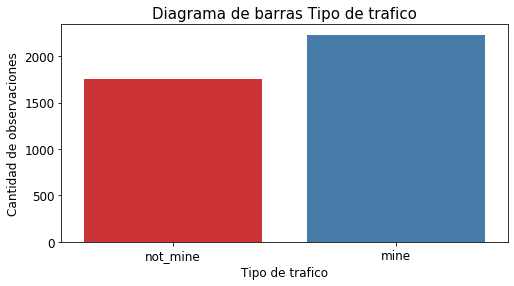

In [311]:
print(colored(f'Balance del conjunto de datos', attrs=['bold']))
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x='Type', data=dataA, palette="Set1")
ax.set_title("Diagrama de barras Tipo de trafico", size=15)
ax.set_xlabel('Tipo de trafico', size = 12)
ax.set_ylabel('Cantidad de observaciones',  size = 12)
ax.tick_params(labelsize = 12)

### OneHotEncoder

In [312]:
data_categoric = dataA[dataA.select_dtypes(include = ['object']).columns.to_list()]
one_hot = OneHotEncoder()
one_hot.fit_transform(data_categoric)

<3983x6 sparse matrix of type '<class 'numpy.float64'>'
	with 7966 stored elements in Compressed Sparse Row format>

In [313]:
data_dummy = pd.get_dummies(data_categoric)
data_dummy.head(2)

,First_Protocol_ICMP,First_Protocol_ICMP6,First_Protocol_TCP,First_Protocol_UDP,Type_mine,Type_not_mine
0,0,0,1,0,0,1
1,0,0,1,0,0,1


In [314]:
dataA = dataA.drop(['First_Protocol','Type'],axis = 1)

In [315]:
dataA = pd.concat([dataA,data_dummy], axis = 1)
dataA.columns

Index(['Netflows', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib',
       'First_Protocol_ICMP', 'First_Protocol_ICMP6', 'First_Protocol_TCP',
       'First_Protocol_UDP', 'Type_mine', 'Type_not_mine'],
      dtype='object')

# Árbol de decisión

In [316]:
best_feature_pure = ['Avg_bps','Avg_bpp' ,'Avg_pps','p3_ip','p3_ib']

In [317]:
y = dataA['Type_mine']
X = dataA[best_feature_pure]

### Holdout

In [318]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7)

### Modelo

In [319]:
print(colored('Instancio el modelo de arbol de decisión', attrs=['bold']))
model = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=5,      
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=None,  
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    class_weight=None)

Instancio el modelo de arbol de decisión


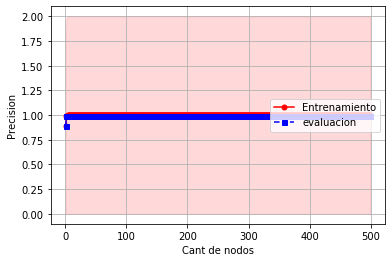

In [320]:
max_deep_list = list(range(1, 500))

curva_validacion(model,X_train,y_train,'max_depth', max_deep_list)

In [321]:
print(colored('Entreno el modelo', attrs=['bold']))
model.fit(X_train,y_train)

Entreno el modelo


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Grafico el modelo
Profundidad del árbol: 5
Número de nodos terminales: 16


[Text(345.84375, 498.3, 'Avg_pps <= 1.5\nsamples = 2788\nvalue = [1249, 1539]\nclass = i'),
 Text(226.6875, 407.70000000000005, 'p3_ib <= 689.0\nsamples = 1826\nvalue = [296, 1530]\nclass = i'),
 Text(104.625, 317.1, 'Avg_bpp <= 28.0\nsamples = 302\nvalue = [294, 8]\nclass = T'),
 Text(46.5, 226.5, 'p3_ib <= 137.0\nsamples = 7\nvalue = [1, 6]\nclass = i'),
 Text(23.25, 135.89999999999998, 'samples = 1\nvalue = [1, 0]\nclass = T'),
 Text(69.75, 135.89999999999998, 'samples = 6\nvalue = [0, 6]\nclass = i'),
 Text(162.75, 226.5, 'p3_ip <= 8.125\nsamples = 295\nvalue = [293, 2]\nclass = T'),
 Text(116.25, 135.89999999999998, 'Avg_bps <= 1157.0\nsamples = 293\nvalue = [292, 1]\nclass = T'),
 Text(93.0, 45.299999999999955, 'samples = 251\nvalue = [251, 0]\nclass = T'),
 Text(139.5, 45.299999999999955, 'samples = 42\nvalue = [41, 1]\nclass = T'),
 Text(209.25, 135.89999999999998, 'Avg_bpp <= 117.0\nsamples = 2\nvalue = [1, 1]\nclass = T'),
 Text(186.0, 45.299999999999955, 'samples = 1\nvalue 

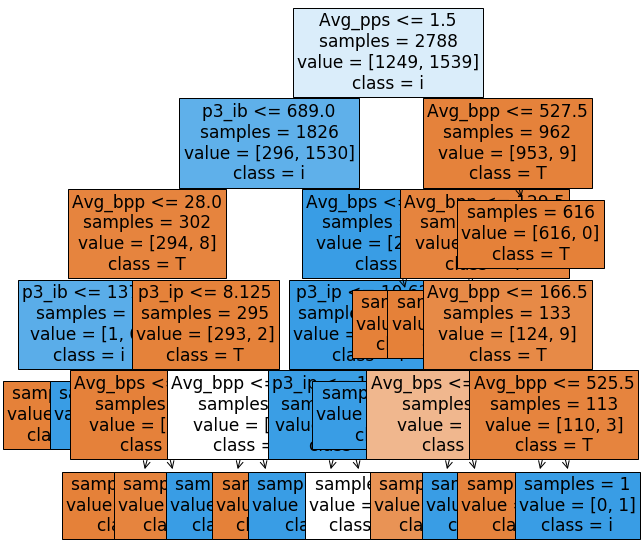

In [322]:
print(colored('Grafico el modelo', attrs=['bold']))
fig, ax = plt.subplots(figsize = (10,10))

print(colored(f'Profundidad del árbol: {model.get_depth()}', attrs=['bold']))
print(colored(f'Número de nodos terminales: {model.get_n_leaves()}', attrs=['bold']))


plot_tree(
    decision_tree = model,
    feature_names = X_train.columns.tolist(),
    class_names   = 'Tipo de trafico minero',
    filled        = True,
    impurity      = False,
    fontsize      = 17,
    ax            = ax
)

In [323]:
print(colored('Realizo la predicción del modelo con la porción de prueba', attrs=['bold']))
y_pred = model.predict(X_test)
y_pred

Realizo la predicción del modelo con la porción de prueba


array([0, 1, 0, ..., 1, 1, 0], dtype=uint8)

In [324]:
len(y_pred[y_pred == 0])

505

In [325]:
len(y_pred[y_pred == 1])

690

In [326]:
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(model, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), loss='0-1_loss')

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

Average expected loss: 0.007
Average bias: 0.006
Average variance: 0.004


### Métricas y matriz de confusión

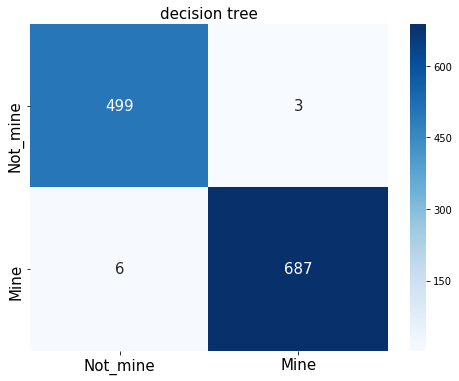

In [327]:
churm = matriz_confusion(y_test, y_pred, plt.cm.Blues)

In [328]:
pd.DataFrame(churm)

,0,1
0,499,3
1,6,687


In [329]:
print("El modelo arbol de dicición se equivocó en %d de los %d registros que componen el dataset de mineria no pura"
      % ((y_test != y_pred).sum(), dataA.shape[0]))

El modelo arbol de dicición se equivocó en 9 de los 3983 registros que componen el dataset de mineria no pura


In [330]:
metricas(y_test, y_pred, churm)

Exactitud:  0.9924686192468619
Kappa:  0.9845550696852853
Metricas de los registros mineros
Precisión:  0.9956521739130435
Recall:  0.9913419913419913
Especificidad :  0.9940239043824701
F1-score      :  0.9934924078091107
Metricas de los registros no mineros
Precisión:  0.9881188118811881
Recall:  0.9940239043824701
Especificidad :  0.9913419913419913
F1-score      :  0.9910625620655412


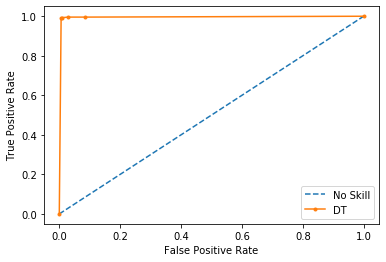

No Skill: ROC AUC=0.500
Treeb: ROC AUC=0.995


In [331]:
ROC(X_test,y_test)

# Experimento 1

In [332]:
print(colored('Importo el conjunto de datos no puros', attrs=['bold']))
dataB = pd.read_csv('./data_no_identificada.csv').drop(['Name','Second_Protocol', 'Third_Protocol'], axis = 1)
dataB.columns

Importo el conjunto de datos no puros


Index(['Netflows', 'First_Protocol', 'p1_d', 'p2_d', 'p3_d', 'duration',
       'max_d', 'min_d', '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes',
       '#sp', '#dp', 'first_sp', 'second_sp', 'third_sp', 'first_dp',
       'second_dp', 'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib',
       'p3_ib', 'Type'],
      dtype='object')

In [333]:
dataB = pd.concat([dataB[dataB.Type == 'mine'],porcion_no_minera_conjuntoA], axis = 0)

### Imputar valores

In [334]:
punter = pd.concat([dataB['second_sp'],dataB['third_sp'],dataB['second_dp'],dataB['third_dp']], axis = 1)
imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
values = imputer.fit_transform(punter)

In [335]:
punter = pd.DataFrame(values, columns = punter.columns)
dataB['second_sp'] = punter['second_sp']
dataB['second_dp'] = punter['second_dp']
dataB['third_sp'] = punter['third_sp']
dataB['third_dp'] = punter['third_dp']

### OneHotEncoder

In [336]:
data_categoric = dataB[dataB.select_dtypes(include = ['object']).columns.to_list()]
one_hot = OneHotEncoder()
one_hot.fit_transform(data_categoric)

<37803x6 sparse matrix of type '<class 'numpy.float64'>'
	with 75606 stored elements in Compressed Sparse Row format>

In [337]:
data_dummy = pd.get_dummies(data_categoric).drop('Type_not_mine',axis=1)
data_dummy.head(2)

,First_Protocol_ICMP,First_Protocol_ICMP6,First_Protocol_TCP,First_Protocol_UDP,Type_mine
0,0,0,1,0,1
1,0,0,1,0,1


In [338]:
dataB = pd.concat([dataB,data_dummy], axis = 1).drop(['First_Protocol','Type'],axis=1)
dataB.columns

Index(['Netflows', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib',
       'First_Protocol_ICMP', 'First_Protocol_ICMP6', 'First_Protocol_TCP',
       'First_Protocol_UDP', 'Type_mine'],
      dtype='object')

In [339]:
X_train.columns

Index(['Avg_bps', 'Avg_bpp', 'Avg_pps', 'p3_ip', 'p3_ib'], dtype='object')

In [340]:
X = dataB[best_feature_pure]
y = dataB['Type_mine']

### Realizo la predicción

In [341]:
y_pred = model.predict(X)
y_pred

array([0, 0, 1, ..., 0, 0, 0], dtype=uint8)

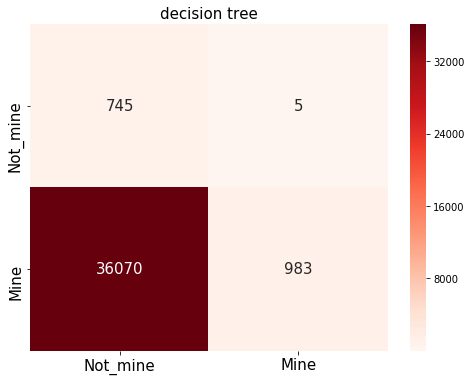

In [342]:
churm = matriz_confusion(y, y_pred, plt.cm.Reds)

In [343]:
pd.DataFrame(churm)

,0,1
0,745,5
1,36070,983


In [344]:
print("El modelo de en el experimento 1 se equivocó en %d de los %d registros que componen el dataset de mineria no pura"
      % ((y != y_pred).sum(), dataB.shape[0]))

El modelo de en el experimento 1 se equivocó en 36075 de los 37803 registros que componen el dataset de mineria no pura


In [345]:
metricas(y, y_pred, churm)

Exactitud:  0.045710657884294896
Kappa:  0.0008088597786217733
Metricas de los registros mineros
Precisión:  0.9949392712550608
Recall:  0.026529565757158664
Especificidad :  0.9933333333333333
F1-score      :  0.051681080938986886
Metricas de los registros no mineros
Precisión:  0.02023631671872878
Recall:  0.9933333333333333
Especificidad :  0.026529565757158664
F1-score      :  0.03966458139225342


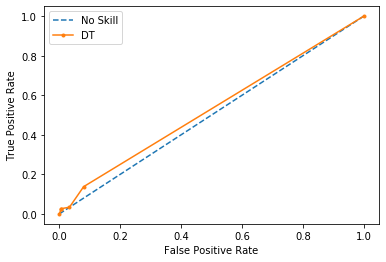

No Skill: ROC AUC=0.500
Treeb: ROC AUC=0.528


In [346]:
ROC(X,y)

# Experimento 2

In [368]:
print(colored('Caracteristicas del conjunto de datos no puro', attrs=['bold']))
best_feature_noPure = ['p3_d','min_d', 'first_sp','first_dp', 'second_sp','second_dp','Type_mine']
print(best_feature_noPure)

Caracteristicas del conjunto de datos no puro
['p3_d', 'min_d', 'first_sp', 'first_dp', 'second_sp', 'second_dp', 'Type_mine']


In [369]:
print(colored('Combino las caracteristicas y agrego la variable objetivo', attrs=['bold']))
bestFeature = np.concatenate([best_feature_pure,best_feature_noPure])
bestFeature = np.unique(bestFeature)
bestFeature

Combino las caracteristicas y agrego la variable objetivo


array(['Avg_bpp', 'Avg_bps', 'Avg_pps', 'Type_mine', 'first_dp',
       'first_sp', 'min_d', 'p3_d', 'p3_ib', 'p3_ip', 'second_dp',
       'second_sp'], dtype='<U9')

In [370]:
print(colored('Aplico una tecnica de submuestreo para equilibrar las clases del conjunto de datos no puros,  con la finalidad de balanciar el conjunto de datos', attrs=['bold']))
porcion_minera_conjuntoB = dataB[dataB.Type_mine == 1]
porcion_minera_conjuntoB = porcion_minera_conjuntoB.sample(n=dataCopyA[dataCopyA.Type == "mine"].shape[0])

Aplico una tecnica de submuestreo para equilibrar las clases del conjunto de datos no puros,  con la finalidad de balanciar el conjunto de datos


In [371]:
print(colored('Unimos los conjuntos de datos y aplicamos aleatoriedad en la posición de los registros', attrs=['bold']))


Unimos los conjuntos de datos y aplicamos aleatoriedad en la posición de los registros


In [372]:
copy_porcion_minera_conjuntoB = porcion_minera_conjuntoB 

In [373]:
data_final = pd.concat([dataA[bestFeature], porcion_minera_conjuntoB[bestFeature], ], axis = 0)
data_final.shape

(6215, 12)

Balance del conjunto de datos


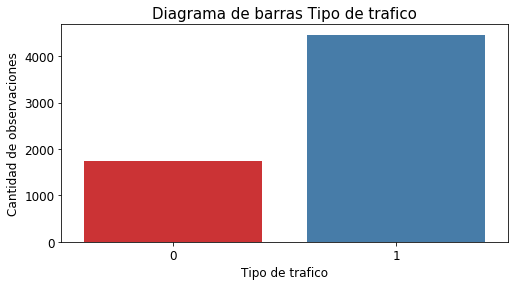

In [374]:
print(colored(f'Balance del conjunto de datos', attrs=['bold']))
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x='Type_mine', data=data_final, palette="Set1")
ax.set_title("Diagrama de barras Tipo de trafico", size=15)
ax.set_xlabel('Tipo de trafico', size = 12)
ax.set_ylabel('Cantidad de observaciones',  size = 12)
ax.tick_params(labelsize = 12)

In [375]:
sobre_muestreo_no_minera = data_final[data_final.Type_mine == 0]
data_final = pd.concat([data_final, sobre_muestreo_no_minera], axis = 0)
data_final.shape

(7966, 12)

Balance del conjunto de datos


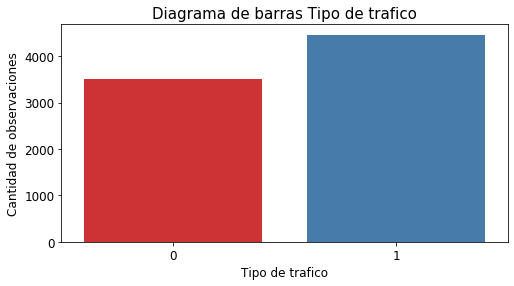

In [376]:

print(colored(f'Balance del conjunto de datos', attrs=['bold']))
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x='Type_mine', data=data_final, palette="Set1")
ax.set_title("Diagrama de barras Tipo de trafico", size=15)
ax.set_xlabel('Tipo de trafico', size = 12)
ax.set_ylabel('Cantidad de observaciones',  size = 12)
ax.tick_params(labelsize = 12)

In [377]:
print(colored('Aleatoriedad', attrs=['bold']))
data_final = data_final.reset_index()
indices = list(data_final.index)
random.shuffle(indices)
data_final = data_final.reindex(indices)
data_final.head()

Aleatoriedad


,index,Avg_bpp,Avg_bps,Avg_pps,Type_mine,first_dp,first_sp,min_d,p3_d,p3_ib,p3_ip,second_dp,second_sp
3279,3898,788,210103,33,0,443,443,0.000,0.0010,73.75,2.0,123.0,123.0
7760,4154,887,424115,59,0,443,443,0.000,6.3935,5248.50,18.5,80.0,80.0
4842,9487,116,190,0,1,34560,0,0.000,0.0000,40.00,1.0,1281.0,49684.0
5469,9688,91,137,0,1,34560,0,0.000,0.0000,40.00,1.0,1281.0,45560.0
436,518,390,569,0,1,3333,3333,581.822,581.8265,30037.50,55.0,50348.0,50348.0


In [378]:
data_final.drop(['index'],axis =1, inplace=True)

In [379]:
data_final['Type_mine'] = data_final['Type_mine'].astype('int')

In [380]:
data_final.shape

(7966, 12)

### Modelo

In [381]:
X = data_final.drop('Type_mine', axis = 1)
y = data_final['Type_mine']

In [382]:
model = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=5,      
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=None,  
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    class_weight=None)

In [383]:
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
scores = cross_validate(model, X, y, scoring=scoring, cv=10, return_train_score=False)

for key in scores:
    score = scores[key]
    print("%s: %0.2f (+/- %0.2f)" % (key, score.mean(), score.std() * 2))


fit_time: 0.07 (+/- 0.02)
score_time: 0.60 (+/- 3.46)
test_accuracy: 1.00 (+/- 0.00)
test_precision_weighted: 1.00 (+/- 0.00)
test_recall_weighted: 1.00 (+/- 0.00)
test_f1_weighted: 1.00 (+/- 0.00)


### Cross Validation-K_fold

In [384]:
K_fold = KFold(n_splits = 10)

In [385]:
resultados_train = []
resultados_test = []
predicciones = []
scores = []
modelos = []


for result in K_fold.split(X):
    resultados_train.append(result[0])
    resultados_test.append(result[1])
    X_train = X.iloc[result[0]]
    X_test =  X.iloc[result[1]]
    y_train =  y.iloc[result[0]]
    y_test =  y.iloc[result[1]]
    model = model.fit(X_train,y_train)
    modelos.append(model)
    predic = model.predict(X_test)
    predicciones.append(predic)
    scores.append(model.score(X_test, y_test))

In [386]:
scores

[1.0,
 0.998745294855709,
 0.9974905897114178,
 0.9937264742785445,
 0.9974905897114178,
 0.9937264742785445,
 0.9974874371859297,
 0.9987437185929648,
 0.9987437185929648,
 0.9987437185929648]

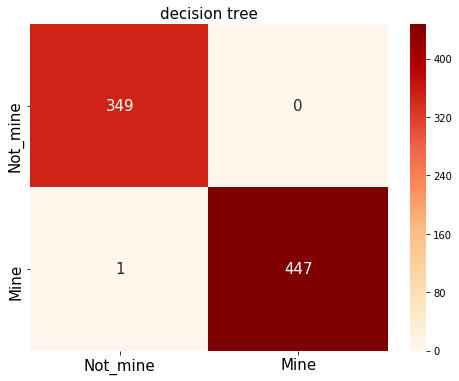

In [387]:
churm = matriz_confusion(y.iloc[resultados_test[1]], predicciones[1], plt.cm.OrRd)

In [389]:
pd.DataFrame(churm)

,0,1
0,349,0
1,1,447


In [390]:
metricas(y.iloc[resultados_test[1]], predicciones[1], churm)

Exactitud:  0.998745294855709
Kappa:  0.9974520704724699
Metricas de los registros mineros
Precisión:  1.0
Recall:  0.9977678571428571
Especificidad :  1.0
F1-score      :  0.9988826815642458
Metricas de los registros no mineros
Precisión:  0.9971428571428571
Recall:  1.0
Especificidad :  0.9977678571428571
F1-score      :  0.9985693848354792


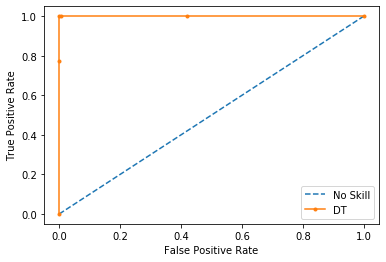

No Skill: ROC AUC=0.500
Treeb: ROC AUC=1.000


In [391]:
ROC(X.iloc[resultados_test[1]],y.iloc[resultados_test[1]])

### Prueba final

In [392]:
porcion_no_minera_conjuntoA.columns

Index(['Netflows', 'First_Protocol', 'p1_d', 'p2_d', 'p3_d', 'duration',
       'max_d', 'min_d', '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes',
       '#sp', '#dp', 'first_sp', 'second_sp', 'third_sp', 'first_dp',
       'second_dp', 'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib',
       'p3_ib', 'Type'],
      dtype='object')

In [393]:
copy_porcion_minera_conjuntoB.columns

Index(['Netflows', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib',
       'First_Protocol_ICMP', 'First_Protocol_ICMP6', 'First_Protocol_TCP',
       'First_Protocol_UDP', 'Type_mine'],
      dtype='object')

In [394]:
data_categoric = porcion_no_minera_conjuntoA[porcion_no_minera_conjuntoA.select_dtypes(include = ['object']).columns.to_list()]
one_hot = OneHotEncoder()
one_hot.fit_transform(data_categoric)
data_dummy = pd.get_dummies(data_categoric)
data_dummy.head(2)

,First_Protocol_TCP,First_Protocol_UDP,Type_not_mine
3377,1,0,1
931,1,0,1


In [395]:
data_dummy = data_dummy.rename(columns = {'Type_not_mine':'Type_mine'})
data_dummy['Type_mine'] = data_dummy['Type_mine'].replace({1:0})

In [396]:
porcion_no_minera_conjuntoA = pd.concat([porcion_no_minera_conjuntoA,data_dummy], axis = 1).drop(['First_Protocol'], axis = 1)

In [397]:
dataB = dataB[~dataB.index.isin(porcion_minera_conjuntoB.index)]

In [398]:
dataB.columns

Index(['Netflows', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib',
       'First_Protocol_ICMP', 'First_Protocol_ICMP6', 'First_Protocol_TCP',
       'First_Protocol_UDP', 'Type_mine'],
      dtype='object')

In [399]:
porcion_no_minera_conjuntoA.columns

Index(['Netflows', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib',
       'Type', 'First_Protocol_TCP', 'First_Protocol_UDP', 'Type_mine'],
      dtype='object')

In [400]:
prueba_final = pd.concat([porcion_no_minera_conjuntoA[bestFeature],dataB[bestFeature]], axis = 0).replace({np.nan:0})

In [401]:
X_p = prueba_final[bestFeature].drop('Type_mine',axis = 1)
y_p = prueba_final['Type_mine']

In [402]:
y_pred_proba = modelos[1].predict(X_p)

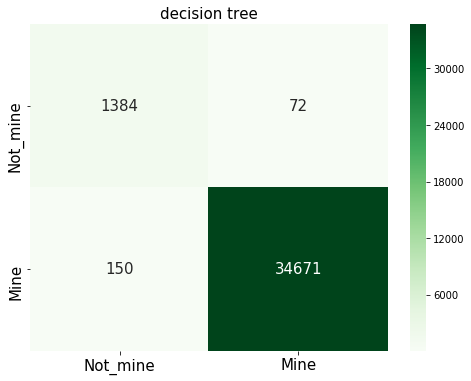

In [403]:
churm = matriz_confusion(y_p, y_pred_proba, plt.cm.Greens)

In [404]:
pd.DataFrame(churm)

,0,1
0,1384,72
1,150,34671


In [405]:
metricas(y_p, y_pred_proba, churm)

Exactitud:  0.9938804201008904
Kappa:  0.9225634675715637
Metricas de los registros mineros
Precisión:  0.9979276401001641
Recall:  0.9956922546739037
Especificidad :  0.9505494505494505
F1-score      :  0.9968086941521477
Metricas de los registros no mineros
Precisión:  0.9022164276401564
Recall:  0.9505494505494505
Especificidad :  0.9956922546739037
F1-score      :  0.9257525083612039


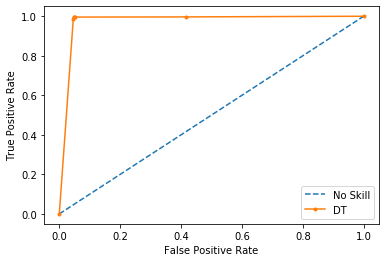

No Skill: ROC AUC=0.500
Treeb: ROC AUC=0.974


In [406]:
ROC(X_p,y_p)

In [ ]:
max_deep_list = list(range(1, 500))

curva_validacion(modelos[1], X_p,y_p,'max_depth', max_deep_list)